# Latent space of VAE


In [1]:
# Import libraries 
import os
import torch
import numpy as np 
from matplotlib import pyplot as plt
from torchvision import transforms
from torchvision.utils import save_image

# Import custom modules
from models.vanilla_vae import VanillaVAE
from lightning_vae import VAELightning
from lightningdata_mnist import MNISTDataModule
from torch_vae.lightningdata_engchar import HandwrittenCharDataModule, load_specific_labels

In [2]:
# Configuration dictionaries
vae_config = {
    'in_channels': 1,
    'latent_dim': 2,
    'hidden_dims': [32, 64],
    'width': 28,
    'height': 28
}
lightning_config = {
    'LR': 0.005,
    'weight_decay': 0.0,
    'scheduler_gamma': 0.95,
    'kld_weight': 0.00025,
    'manual_seed': 1265
}
data_config = {
    'data_dirpath': "/mounted_data/downloaded",
    'batch_size': 256
}

# Path to your checkpoint file
checkpoint_path = '/workspace/torch_vae/logs/VanillaVAE/version_15/checkpoints/last.ckpt'

In [3]:
# Load the trained LightningModule from the checkpoint
vae_model = VanillaVAE(**vae_config)
trained_model = VAELightning.load_from_checkpoint(
    checkpoint_path=checkpoint_path,
    vae_model=vae_model,
    params=lightning_config
)
# Set the model to evaluation mode and move to the appropriate device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
trained_model.eval()
trained_model.to(device)

VAELightning(
  (model): VanillaVAE(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (fc_mu): Linear(in_features=3136, out_features=2, bias=True)
    (fc_var): Linear(in_features=3136, out_features=2, bias=True)
    (decoder_input): Linear(in_features=2, out_features=3136, bias=True)
    (decoder): Sequential(
      (0): Sequential(
        (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )

In [4]:
# Get the MNIST test dataloader
mnist_datamodule = MNISTDataModule(data_dir=data_config['data_dirpath'])
mnist_datamodule.setup('test')
test_dataloader = mnist_datamodule.test_dataloader()

# Collect latent variables and labels from MNIST test set
mnist_latents = []
mnist_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        # Pass through the encoder to get mu and log_var
        mu, log_var = trained_model.model.encode(images)
        # Sample z using reparameterization
        z = trained_model.model.reparameterize(mu, log_var)
        # Collect z and labels
        mnist_latents.append(z.cpu())
        mnist_labels.append(labels.cpu())

# Concatenate all latents and labels
mnist_latents = torch.cat(mnist_latents, dim=0)
mnist_labels = torch.cat(mnist_labels, dim=0)

# Convert to NumPy arrays for plotting
mnist_latents_np = mnist_latents.numpy()
mnist_labels_np = mnist_labels.numpy()

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


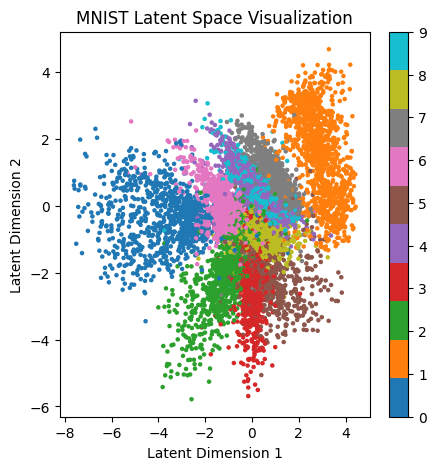

In [9]:
# Plot the latent space for MNIST test set
plt.figure(figsize=(5, 5))
scatter = plt.scatter(mnist_latents_np[:, 0], mnist_latents_np[:, 1], c=mnist_labels_np, cmap='tab10', s=5)
plt.colorbar(scatter, ticks=range(10))
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('MNIST Latent Space Visualization')
plt.show()

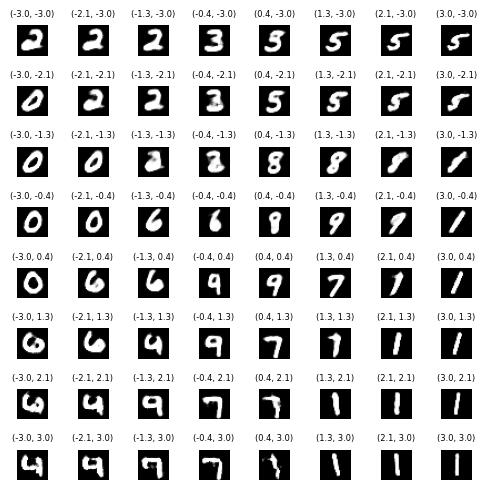

In [13]:
# Generate a grid of latent vectors
n = 8
figure = plt.figure(figsize=(5, 5))
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

# Generate images by decoding the latent vectors
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
        with torch.no_grad():
            generated_image = trained_model.model.decode(z_sample).cpu()
        ax = plt.subplot(n, n, i * n + j + 1)
        plt.imshow(generated_image.squeeze().numpy(), cmap='gray')
        ax.axis('off')
        ax.set_title(f"({xi:.1f}, {yi:.1f})", fontsize=6)

figure.tight_layout() 
plt.show()

## What if the encoder sees something that it never saw before? 

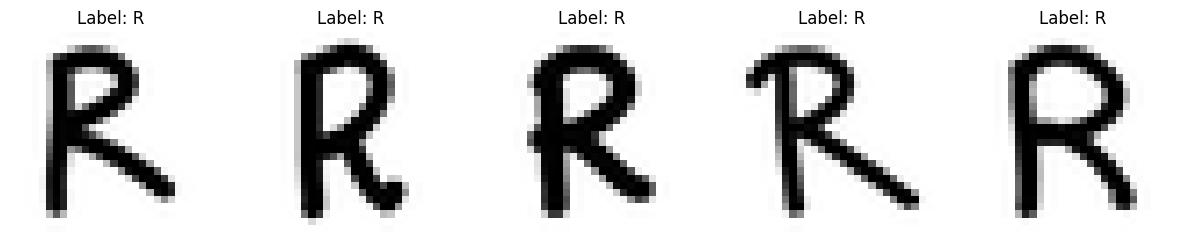

In [15]:
# Load and process handwritten character data (e.g., letter 'K')
engchar_datamodule = HandwrittenCharDataModule(
    dataset_dir='/mounted_data/downloaded/EngLetters',
    batch_size=256
)
char_images_list, char_labels = load_specific_labels(engchar_datamodule, ['R'])
char_images = torch.cat(char_images_list, dim=0)
char_images = char_images[:, None, :, :]  # Add channel dimension if necessary

# Show first 5 images and labels of the character dataset
char_images_np = char_images.cpu().numpy()
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    ax = axes[i]
    img = char_images_np[i].squeeze(0)  # Remove the channel dimension
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Label: {char_labels[i]}')
    ax.axis('off')
plt.show()

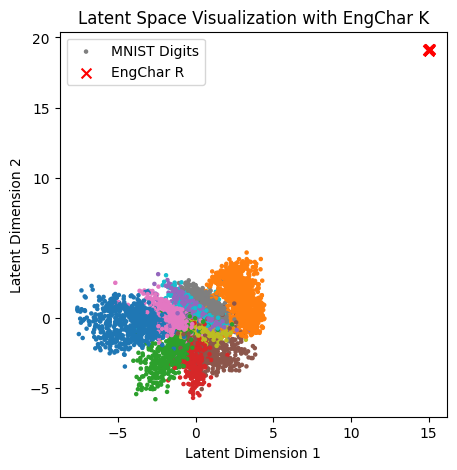

In [16]:
# Collect latent variables for the handwritten characters
with torch.no_grad():
    char_images = char_images.to(device)
    mu, log_var = trained_model.model.encode(char_images)
    z = trained_model.model.reparameterize(mu, log_var)
    char_latents = z.cpu()

# Convert to NumPy arrays for plotting
char_latents_np = char_latents.numpy()

# Overlay the character data on the MNIST latent space
plt.figure(figsize=(5, 5))
plt.scatter(mnist_latents_np[:, 0], mnist_latents_np[:, 1], c=mnist_labels_np, cmap='tab10', s=5, label='MNIST Digits')
plt.scatter(char_latents_np[:, 0], char_latents_np[:, 1], marker='x', s=50, color='red', label='EngChar R')
plt.legend()
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization with EngChar K')
plt.show()